In [1]:
import pandas as pd
import sys
import numpy as np
import os
import json
import re
import torch
import ast
import cv2
import io
from PIL import Image, ImageDraw
from torch import Tensor
import torchvision
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection import FasterRCNN

import math
from math import sqrt

In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
from RPN_custom import RPN_custom

In [4]:
torch.__version__

'1.7.0+cu101'

In [5]:
"'1.7.0+cu101'"
#Cuda compilation tools, release 10.1, V10.1.105

"'1.7.0+cu101'"

In [6]:
from torchvision.transforms import functional as F

def collate_fn(batch):
    return tuple(zip(*batch))



def resize_bbox(image_shape, newsize, bbox):
    x1, y1, w, h = bbox
    w_conv = newsize[0]/image_shape[0]
    h_conv = newsize[1]/image_shape[1]
    (x1, y1, w, h) = (x1*w_conv, y1*h_conv, w*w_conv, h*h_conv)
    return x1, y1, w, h




def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    b1x1,b1y1,b1x2,b1y2 = bb1[0],bb1[1],bb1[2],bb1[3]
    b2x1,b2y1,b2x2,b2y2 = bb2[0],bb2[1],bb2[2],bb2[3]
    
    
    assert b1x1 < b1x2
    assert b1y1 < b1y2
    assert b2x1 < b2x2
    assert b2y1 < b2y2

    # determine the coordinates of the intersection rectangle
    x_left = max(b1x1, b2x1)
    y_top = max(b1y1, b2y1)
    x_right = min(b1x2, b2x2)
    y_bottom = min(b1y2, b2y2)

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (b1x2 - b1x1) * (b1y2 - b1y1)
    bb2_area = (b2x2 - b2x1) * (b2y2 - b2y1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [7]:
min_size = 550  
max_size = 700  

image_means = [0.9492,0.9492,0.9492]
image_stds = [0.1158,0.1158,0.1158]

In [8]:
num_classes = 2

#backbone = resnet_fpn_backbone('resnet50', True)
#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
backbone = resnet_fpn_backbone('resnet50', True)
model = RPN_custom(backbone, num_classes, min_size=min_size, max_size=max_size, image_mean = image_means , image_std = image_stds)
model.load_state_dict(torch.load(r"C:\Users\Jesper\Desktop\Jakob_Detection_Training\RPNresnet50\model.pt"))



model.eval()

RPN_custom(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.9492, 0.9492, 0.9492], std=[0.1158, 0.1158, 0.1158])
      Resize(min_size=(550,), max_size=700, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsa

In [9]:
Annotations_train = pd.read_csv('Detection/annotations/Annotations_train_sample.csv')
Annotations_valid = pd.read_csv('Detection/annotations/Annotations_test_sample.csv')
Annotations_temp = pd.read_csv('Detection/annotations/Annotations.csv')

In [10]:
#Create test data
testdf = Annotations_temp.join(Annotations_train.set_index('filename'),on='filename',how='outer',rsuffix='rr')

testdf = testdf[testdf['Typerr'].isna()]
testdf = testdf[['filename','BoundingBoxes']].sample(n=10000,random_state=420, axis=0)

In [11]:
testdf.head()

,filename,BoundingBoxes
22704,1407.7739_16.jpg,"[[72, 418, 469, 232]]"
58989,1507.00459_7.jpg,"[[260, 146, 95, 92]]"
57782,1506.06700_4.jpg,"[[51, 93, 503, 393]]"
45419,1503.01331_2.jpg,"[[350, 114, 174, 263]]"
51940,1504.08349_31.jpg,"[[80, 68, 450, 105]]"


In [12]:
class TableBank():
    def __init__(self,images_path, df, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
       
        self.annotations = df
        self.images_path = images_path
        #self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = os.path.join(self.images_path,
                                self.annotations.iloc[idx]['filename'])
        
        image = Image.open(img_path).convert("RGB")
        image_shape = image.size
        newsize = (550,700)
        image = image.resize(newsize,resample=Image.BILINEAR)
        bboxes = ast.literal_eval(self.annotations.iloc[idx]['BoundingBoxes'])

        #boxes = np.zeros((1,4), dtype=np.float32)
        areas = []
        boxes = []
        for i in range(len(bboxes)):
            (x1, y1, w, h) = resize_bbox(image_shape, newsize, bboxes[i])
            x2 = x1+w
            y2 = y1+h
            boxes.append([x1,y1,x2,y2])
            areas.append((h*w))
            #if area < h*w:
            #    area = h*w
            #    boxes[0,:] = [x1,y1,x2,y2]

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((len(boxes)), dtype=torch.int64)
        #labels = torch.ones(1, dtype = torch.int64)
        areas = torch.as_tensor(areas, dtype=torch.int64)
        iscrowd = torch.zeros(len(boxes), dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([idx])
        target["area"] = areas
        target["iscrowd"] = iscrowd        

        image = F.to_tensor(image)

        return image, target,self.annotations.iloc[idx]['filename']

In [13]:
images_path = 'Detection/images/'
TBtest = TableBank(images_path, testdf)

In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [15]:
dataloader = torch.utils.data.DataLoader(TBtest, batch_size=8,
                                sampler=None, num_workers=0, collate_fn=collate_fn)

# Get predictions on test set

In [16]:
testdf['predictions'] = None
testdf['scores'] = None
testdf = testdf.set_index('filename')

# Ikke kør nedenstående , kommer til at tage max lang tid.
Se istedet nedenfor hvordan du indlæser testdf fra pickle

In [17]:
model.eval()

RPN_custom(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.9492, 0.9492, 0.9492], std=[0.1158, 0.1158, 0.1158])
      Resize(min_size=(550,), max_size=700, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsa

In [18]:
from time import time

t = time()  
   
model.to(device)
model.eval()
    
for ct, obj in enumerate(dataloader):
    img = obj[0]
    annotations = obj[1]
    filename = obj[2]
    with(torch.no_grad()):
        #Get predictions 
        images = list(image.to(device) for image in img)
        #targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        predictions = model(images)
        
    #input predictions in df for later calculations
    count = 0
    for pred,idx in zip(predictions,filename):
        #only keep predictions with confidence over 0.9
        
        #temp_boxes = []
        #temp_scores = []
        #for box,score in zip(pred['boxes'].cpu().numpy(),pred['scores'].cpu().numpy()):
        #    if score >= 0.9:
        #        temp_boxes.append(box)
        #        temp_scores.append(score)
        
        
        #testdf.loc[idx]['predictions'] = temp_boxes
        #testdf.loc[idx]['scores'] = temp_scores
        
        testdf.loc[idx]['BoundingBoxes'] = obj[1][count]['boxes'].numpy()
        testdf.loc[idx]['predictions'] = pred['boxes'].cpu().numpy()
        testdf.loc[idx]['scores'] = pred['scores'].cpu().numpy()
        
        count+=1 
    #print(ct)
    if ct % 20 == 0:
        tottime = (time()-t)/20
        print(f"Counter: {ct}/1250. Average time per loop iteration: {tottime:.5f} sec.")
        t = time()

Counter: 0/1250. Average time per loop iteration: 0.08379 sec.
Counter: 20/1250. Average time per loop iteration: 0.39696 sec.
Counter: 40/1250. Average time per loop iteration: 0.39684 sec.
Counter: 60/1250. Average time per loop iteration: 0.39773 sec.
Counter: 80/1250. Average time per loop iteration: 0.39506 sec.
Counter: 100/1250. Average time per loop iteration: 0.39884 sec.
Counter: 120/1250. Average time per loop iteration: 0.39770 sec.
Counter: 140/1250. Average time per loop iteration: 0.39906 sec.
Counter: 160/1250. Average time per loop iteration: 0.39838 sec.
Counter: 180/1250. Average time per loop iteration: 0.39755 sec.
Counter: 200/1250. Average time per loop iteration: 0.39777 sec.
Counter: 220/1250. Average time per loop iteration: 0.39804 sec.
Counter: 240/1250. Average time per loop iteration: 0.39672 sec.
Counter: 260/1250. Average time per loop iteration: 0.39585 sec.
Counter: 280/1250. Average time per loop iteration: 0.39740 sec.
Counter: 300/1250. Average time

In [19]:
testdf = testdf.reset_index()

In [30]:
testdf.head(50)

,filename,BoundingBoxes,predictions,scores
0,1407.7739_16.jpg,"[[66.442955, 347.50595, 499.24496, 540.38007]]","[[136.95868, 346.84552, 490.31775, 531.29254],...","[0.9976073688881798, 0.9940744020918562, 0.979..."
1,1507.00459_7.jpg,"[[233.66013, 129.0404, 319.03595, 210.35353]]","[[219.76509, 141.86708, 319.48886, 192.92778],...","[0.9945073039310146, 0.9900443674603479, 0.985..."
2,1506.06700_4.jpg,"[[45.833332, 82.19697, 497.87582, 429.54544]]","[[57.858505, 190.4555, 335.53314, 442.86267], ...","[0.9944341094056707, 0.9915940285429865, 0.990..."
3,1503.01331_2.jpg,"[[314.54248, 100.757576, 470.91504, 333.20706]]","[[300.73868, 97.82908, 469.87674, 206.87009], ...","[0.9885311490625546, 0.9546601969921055, 0.952..."
4,1504.08349_31.jpg,"[[71.895424, 60.10101, 476.3072, 152.90404]]","[[284.58093, 63.22213, 481.0807, 136.5492], [8...","[0.9837342552122811, 0.9808528813285504, 0.520..."
5,1406.2022_2.jpg,"[[49.832214, 124.70309, 267.61746, 189.54869],...","[[41.60637, 116.92619, 262.15912, 194.34065], ...","[0.8663047782657814, 0.7573366339509313, 0.740..."
6,&file=1402130085ULiDq20101008_3.jpg,"[[169.79866, 59.026127, 394.96643, 228.62233],...","[[93.3533, 145.00208, 490.23495, 311.71762], [...","[0.7402426982738469, 0.7243982122134873, 0.668..."
7,1501.05724_5.jpg,"[[175.33557, 200.3563, 392.198, 249.40617], [2...","[[222.81006, 359.69257, 320.22687, 409.0121], ...","[0.9921632874392777, 0.9920733307213936, 0.990..."
8,1406.5935_2.jpg,"[[48.52941, 60.10101, 266.01306, 335.85858]]","[[44.632446, 101.5331, 262.53714, 347.68323], ...","[0.9791761947716412, 0.968707421385879, 0.8828..."
9,1504.00548_5.jpg,"[[75.4902, 63.636364, 485.29413, 227.14647], [...","[[68.38399, 74.260254, 411.99042, 220.57596], ...","[0.9022890569423582, 0.9022288396391049, 0.763..."


In [38]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def sigmoid_df(row):
    v = np.array([])
    x = row['scores']
    for i in x:
        v.append(sigmoid(i)) 
    return v

In [27]:
#only for RPN
testdf['scores'] = testdf.apply(lambda row: sigmoid_df(row), axis=1)

In [31]:
testdf.to_csv('RPNresnet50/testscores.csv')

In [32]:
from PIL import Image

In [33]:
index = 0
nr = 0
bb = 0

In [36]:
def nms(boxes: Tensor, scores: Tensor, iou_threshold: float) -> Tensor:
    return torch.ops.torchvision.nms(boxes, scores, iou_threshold)

In [56]:
bboxes = torch.from_numpy(testdf.iloc[index]['predictions']).type(torch.DoubleTensor)
scores = torch.from_numpy(testdf.iloc[index]['scores']).type(torch.DoubleTensor)

In [60]:
_slice = nms(bboxes, scores,0.1)

In [65]:
GTboxes = testdf.iloc[index]['BoundingBoxes']
numGT = len(GTboxes)

i = 0
for gt in GTboxes:
    i+=1
    print('GTbox ', i)    
    for bb_ in _slice:
        print('box: ', bb_, 'score: ', scores[bb_], 'IoU: ', get_iou(gt, bboxes[bb_]))

GTbox  1
box:  tensor(0) score:  tensor(0.9976, dtype=torch.float64) IoU:  tensor(0.7758, dtype=torch.float64)
box:  tensor(41) score:  tensor(0.0316, dtype=torch.float64) IoU:  0.0
box:  tensor(53) score:  tensor(0.0177, dtype=torch.float64) IoU:  0.0
box:  tensor(59) score:  tensor(0.0137, dtype=torch.float64) IoU:  tensor(0.1583, dtype=torch.float64)
box:  tensor(64) score:  tensor(0.0129, dtype=torch.float64) IoU:  0.0
box:  tensor(66) score:  tensor(0.0126, dtype=torch.float64) IoU:  0.0
box:  tensor(75) score:  tensor(0.0098, dtype=torch.float64) IoU:  0.0
box:  tensor(77) score:  tensor(0.0090, dtype=torch.float64) IoU:  0.0
box:  tensor(106) score:  tensor(0.0057, dtype=torch.float64) IoU:  0.0
box:  tensor(128) score:  tensor(0.0044, dtype=torch.float64) IoU:  0.0
box:  tensor(132) score:  tensor(0.0041, dtype=torch.float64) IoU:  0.0
box:  tensor(237) score:  tensor(0.0012, dtype=torch.float64) IoU:  0.0
box:  tensor(282) score:  tensor(0.0007, dtype=torch.float64) IoU:  0.0


In [68]:
img_path = os.path.join(images_path,
                                testdf.iloc[index]['filename'])
image = Image.open(img_path).convert("RGB")
image_shape = image.size
newsize = (550,700)
image = image.resize(newsize)

In [71]:
bboxes = [testdf.iloc[index]['predictions'][nr]]
(x1_, y1_, x2_, y2_) = bboxes[0]

(x1, y1, x2, y2) = testdf.iloc[index]['BoundingBoxes'][bb]

In [73]:
print('ground truth: ',x1, y1, x2, y2)
print('predicted: ', x1_, y1_, x2_, y2_)
print('IoU: ', get_iou([x1, y1, x2, y2], [x1_, y1_, x2_, y2_]))
print('score: ', testdf.iloc[index]['scores'][nr])

ground truth:  66.442955 347.50595 499.24496 540.38007
predicted:  136.95868 346.84552 490.31775 531.29254
IoU:  0.7758083230003104
score:  0.9976073688881798


In [74]:
for i in range(len(bboxes)):
    #prediction coordinates
    x1_, y1_, x2_, y2_ = bboxes[i]
    
    draw = ImageDraw.Draw(image)
    draw.rectangle([x1, y1, x2, y2], outline=(255, 0, 0, 0), width=2)
    draw.rectangle([x1_, y1_, x2_, y2_], outline=(0, 255, 0, 0), width=2)
        
savepath = 'predicted images/im_{}.png'.format(idx)
image.save(savepath)

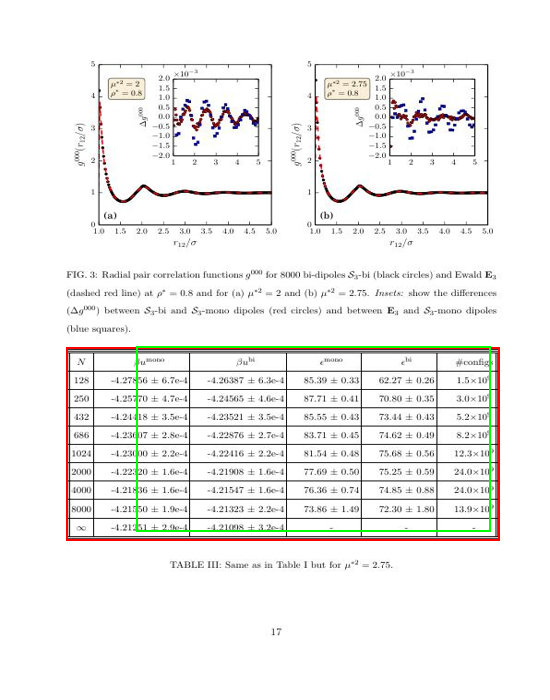

In [75]:
Image.open(savepath).convert('RGB')

# Statistics

In [150]:
'''
TBstats = TableBank(images_path, Annotations_train[['filename','BoundingBoxes']])
dataloader_stats = torch.utils.data.DataLoader(TBstats, batch_size=8,
                                sampler=None, num_workers=0, collate_fn=collate_fn)
mean = 0.
#std = 0.
nb_samples = 0

t = time()  
for ct,dataL in enumerate(dataloader_stats):
    #print(dataL[0])
    data = dataL[0]
    
    for d in data:
        mean+=d.mean().item()
        nb_samples+=1
    
    #print(ct)
    if ct % 20 == 0:
        tottime = (time()-t)/20
        print(f"Counter: {ct}/2540. Average time per loop iteration: {tottime:.5f} sec.")
        t = time()
    
print(nb_samples)


mean /= nb_samples


#Standard deviation
std = 0.

total_pixels= 0
t = time()  
for ct,dataL in enumerate(dataloader_stats):
    data = dataL[0]
    for elem in data:
        

        total_pixels+= elem.size()[0]*elem.size()[1]*elem.size()[2]

        #Get squared deviation for all pixels
        std += ((elem-mean) * (elem-mean)).sum().item()
    #print(ct)
    if ct % 20 == 0:
        tottime = (time()-t)/20
        print(f"Counter: {ct}/2540. Average time per loop iteration: {tottime:.5f} sec.")
        t = time()

#To get true unbiased std, take -1 
std =sqrt(std/(total_pixels-1))
print("Image Means: ", mean)
print("Image std_: ",std)
'''

Counter: 0/2540. Average time per loop iteration: 0.00415 sec.
Counter: 20/2540. Average time per loop iteration: 0.07737 sec.
Counter: 40/2540. Average time per loop iteration: 0.07765 sec.
Counter: 60/2540. Average time per loop iteration: 0.07537 sec.
Counter: 80/2540. Average time per loop iteration: 0.07627 sec.
Counter: 100/2540. Average time per loop iteration: 0.07642 sec.
Counter: 120/2540. Average time per loop iteration: 0.07847 sec.
Counter: 140/2540. Average time per loop iteration: 0.07782 sec.
Counter: 160/2540. Average time per loop iteration: 0.07652 sec.
Counter: 180/2540. Average time per loop iteration: 0.07682 sec.
Counter: 200/2540. Average time per loop iteration: 0.07487 sec.
Counter: 220/2540. Average time per loop iteration: 0.07627 sec.
Counter: 240/2540. Average time per loop iteration: 0.07682 sec.
Counter: 260/2540. Average time per loop iteration: 0.07712 sec.
Counter: 280/2540. Average time per loop iteration: 0.07682 sec.
Counter: 300/2540. Average time

Counter: 2500/2540. Average time per loop iteration: 0.07522 sec.
Counter: 2520/2540. Average time per loop iteration: 0.07712 sec.
Counter: 2540/2540. Average time per loop iteration: 0.07602 sec.
20433
Counter: 0/2540. Average time per loop iteration: 0.00460 sec.
Counter: 20/2540. Average time per loop iteration: 0.09287 sec.
Counter: 40/2540. Average time per loop iteration: 0.08927 sec.
Counter: 60/2540. Average time per loop iteration: 0.08952 sec.
Counter: 80/2540. Average time per loop iteration: 0.09104 sec.
Counter: 100/2540. Average time per loop iteration: 0.09035 sec.
Counter: 120/2540. Average time per loop iteration: 0.08985 sec.
Counter: 140/2540. Average time per loop iteration: 0.09172 sec.
Counter: 160/2540. Average time per loop iteration: 0.09167 sec.
Counter: 180/2540. Average time per loop iteration: 0.09071 sec.
Counter: 200/2540. Average time per loop iteration: 0.09037 sec.
Counter: 220/2540. Average time per loop iteration: 0.08977 sec.
Counter: 240/2540. Ave

Counter: 2440/2540. Average time per loop iteration: 0.08910 sec.
Counter: 2460/2540. Average time per loop iteration: 0.08895 sec.
Counter: 2480/2540. Average time per loop iteration: 0.08996 sec.
Counter: 2500/2540. Average time per loop iteration: 0.08854 sec.
Counter: 2520/2540. Average time per loop iteration: 0.08872 sec.
Counter: 2540/2540. Average time per loop iteration: 0.08912 sec.
Image Means:  0.9492457621610854
Image std_:  0.11579399022860752


In [144]:
from math import sqrt
std = 0.

total_pixels= 0
t = time()  
for ct,dataL in enumerate(dataloader_stats):
    data = dataL[0]
    for elem in data:
        

        total_pixels+= elem.size()[0]*elem.size()[1]*elem.size()[2]

        #Get squared deviation for all pixels
        std += ((elem-mean) * (elem-mean)).sum().item()
    #print(ct)
    if ct % 20 == 0:
        tottime = (time()-t)/20
        print(f"Counter: {ct}/2540. Average time per loop iteration: {tottime:.5f} sec.")
        t = time()
std /= total_pixels

Counter: 0/2540. Average time per loop iteration: 0.00445 sec.
Counter: 20/2540. Average time per loop iteration: 0.08839 sec.
Counter: 40/2540. Average time per loop iteration: 0.09002 sec.
Counter: 60/2540. Average time per loop iteration: 0.08692 sec.
Counter: 80/2540. Average time per loop iteration: 0.08882 sec.
Counter: 100/2540. Average time per loop iteration: 0.08912 sec.
Counter: 120/2540. Average time per loop iteration: 0.08992 sec.
Counter: 140/2540. Average time per loop iteration: 0.08982 sec.
Counter: 160/2540. Average time per loop iteration: 0.08992 sec.
Counter: 180/2540. Average time per loop iteration: 0.08972 sec.
Counter: 200/2540. Average time per loop iteration: 0.08925 sec.
Counter: 220/2540. Average time per loop iteration: 0.08969 sec.
Counter: 240/2540. Average time per loop iteration: 0.09011 sec.
Counter: 260/2540. Average time per loop iteration: 0.08809 sec.
Counter: 280/2540. Average time per loop iteration: 0.08792 sec.
Counter: 300/2540. Average time

Counter: 2500/2540. Average time per loop iteration: 0.08747 sec.
Counter: 2520/2540. Average time per loop iteration: 0.08832 sec.
Counter: 2540/2540. Average time per loop iteration: 0.08847 sec.


In [76]:
import pickle

with open(r"C:\Users\Jesper\Desktop\Jakob_Detection_Training\RPNresnet50\losses train dict RPNresnet50.pickle",'rb') as handle:
    Ls = pickle.load(handle)
    
with open(r"C:\Users\Jesper\Desktop\Jakob_Detection_Training\RPNresnet50\losses val dict RPNresnet50.pickle",'rb') as handle:
    Ls_val = pickle.load(handle)   


Text(0.5, 0, 'Epochs')

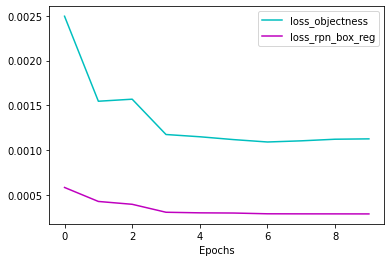

In [77]:
import matplotlib.pyplot as plt
epoch = np.arange(10)
plt.figure()
plt.plot(epoch, Ls_val['loss_objectness'], 'c', epoch, Ls_val['loss_rpn_box_reg'], 'm')
plt.legend(['loss_objectness', 'loss_rpn_box_reg'])
plt.xlabel('Epochs')
#plt.ylabel('Training Loss {}'.format(model_name))
#plt.savefig(output_loc+'Training Loss {}.png'.format(model_name))

In [47]:
def TP_FP(preds,scores,targets,IoU_thresh,pred_thresh):
    #Beregner TP, FP og FN baserert på targets og predictions
    
    #Bliver kaldt elementvist på hver række fra dataframe
    
    
    TP = 0
    FP = 0
    FN = 0
    selected = np.zeros(len(targets))
    for pred,score in zip(preds,scores):
        
        max_iou = 0
        target_loc = None
        if score >= pred_thresh:
            #Iterate over all targets to identify largest IoU
            for i,tgt in enumerate(targets):
                iou = get_iou(pred,tgt)
                if iou >= max_iou:
                    max_iou = iou
                    target_loc = i
                  
            #If targets IoU is over threshold, then prediction is correctly classified
            if max_iou >= IoU_thresh:
                
                #Test if target has already been "selected" by other prediction
                if selected[target_loc] != 1:
                    selected[target_loc] = 1
                    TP+=1
                else:
                    #If target have already been assigned a positive prediction, then the following predictions on this target 
                    #are classified as false positives
                    FP+=1
                    
            #If not IoU over threashold, then prediction is false positive
            else:
                FP+=1
            
    
    #False negatives are targets that have not been predicted
    FN = len(targets)-TP
    if FN < 0:
        print(TP,FP,FN)
    
    return TP,FP,FN
        

#######VIGTIG#########    
TP_FP_vec = np.vectorize(TP_FP)  

#Vectorisering af funktionen gør at vi kan kalde funktionen på alle elementer i hver række i df. 
######################
    
def precision_recall(targets_series,preds_series,scores_series,IoU,pred_thresh):
    
    TP_ar,FP_ar,FN_ar = TP_FP_vec(preds_series,scores_series,targets_series,IoU,pred_thresh)
    
    TP = sum(TP_ar)
    FP = sum(FP_ar)
    FN = sum(FN_ar)
    
    
    return TP/(TP+FP),TP/(TP+FN)
  
    
    
    
    
def precision_recall_curve(df,IoU):
    
    targets_series = df['BoundingBoxes']
    preds_series = df['predictions']
    scores_series = df['scores']
    
    precisions = []
    recalls = []
    
    for thresh in np.arange(0.0,1.0,0.05):
        prec, rec = precision_recall(targets_series,preds_series,scores_series,IoU,thresh)
        precisions.append(prec)
        recalls.append(rec)
    
    return precisions,recalls
    

In [387]:
precision_recall_curve(testdf,0.5)

([0.418047630437011,
  0.418047630437011,
  0.5321599019221507,
  0.6257960958939575,
  0.7050439882697948,
  0.7568592742445316,
  0.7860434496379197,
  0.8088155392556371,
  0.8314551690347869,
  0.8516732637639438,
  0.8690852895724483,
  0.8848061316501352,
  0.8976907784064841,
  0.9085129477438363,
  0.9163402788657371,
  0.9239405439595193,
  0.9323686945399312,
  0.9410384988676803,
  0.9493091325320906,
  0.9597868620431271],
 [0.9752889597449182,
  0.9752889597449182,
  0.9688322040653646,
  0.9634117178158629,
  0.9582303706656038,
  0.9543244320446393,
  0.9517736149860502,
  0.9493025109605421,
  0.9469111199681148,
  0.9433240334794739,
  0.9414109206855321,
  0.9386209645277003,
  0.9358310083698684,
  0.9340773216420885,
  0.9324830609804703,
  0.9315265045834994,
  0.9296931048226384,
  0.927461139896373,
  0.9255480271024312,
  0.9189318453567158])